In [1]:
%load_ext autoreload
%autoreload 2
import DriftMLP
import numpy as np
import DriftMLP.shortest_path as SP 
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from DriftMLP.drifter_indexing.discrete_system import h3_default
loc1 = 149, -40
loc2 = -74.8, -53
if 'nets' not in locals():
    nets = pickle.load(open('rotations_100.p', 'rb'))

Rare long-distance dispersal of marine angiosperm across the pacific Ocean
Figure 2

In [2]:
from_h3 = loc1
plot_n=len(nets)
from shapely.geometry import Point
def path_and_df(network, original_gpd):
    indices = DriftMLP.helpers.return_h3_inds(origins, rot=network['rotation'])
    paths = [DriftMLP.shortest_path.get_all_paths(network, src, indices) for src in  indices]
    ##We didn't store all the gpd dataframes originally as its' costly memorywise
    rot = network['rotation']
    h3_df = DriftMLP.plotting.make_h3_gpd.network_to_multipolygon_df(network)
    return {'paths':paths, 'gpd':h3_df, 'rot':rot}


def get_singleSP(net, loc1, loc2):
    discretizer = h3_default(res=3, rot=net['rotation'])
    return SP.SingleSP(net, loc1, loc2, discretizer=discretizer)

sps= [get_singleSP(net, loc1, loc2) for net in nets]

In [3]:
hasattr(sps[0].discretizer,"ind_to_geo")

True

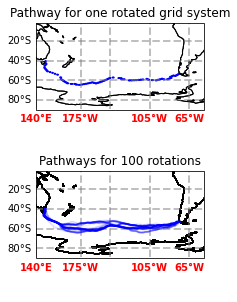

In [7]:
import matplotlib.ticker as mticker

fig = plt.figure(figsize=(3,5))
ax = fig.add_subplot(2,1,1, projection=ccrs.PlateCarree(central_longitude=180))
ax_all = fig.add_subplot(2,1,2, projection=ccrs.PlateCarree(central_longitude=180))

sps[0].plot_cartopy(rev=False, ax=ax)
ax.coastlines()

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def add_rare_gridlines(ax):
    ##Gridlines to match the other papers grid lines 
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.left_labels = True
    gl.xlines = True
    gl.xlocator = mticker.FixedLocator([140,  -175,-145, -105, -65])
    gl.ylocator = mticker.FixedLocator([0,-20,-40,-60,-80])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 15, 'color': 'gray'}
    gl.xlabel_style = {'color': 'red', 'weight': 'bold'}
add_rare_gridlines(ax)
ax.set_extent([140,-50, -80,-40])

for k in sps:
    k.plot_cartopy(rev=False, ax=ax_all, type_plot='line', alpha=0.08, crs=ccrs.Geodetic())
add_rare_gridlines(ax_all)
ax_all.set_extent([140,-50, -80,-40])
ax.set_title("Pathway for one rotated grid system")
ax_all.set_title("Pathways for 100 rotations")
fig.savefig("Images/RareComp_pathways.png")

In [5]:
import h3.api.basic_int as h3
ind = h3.geo_to_h3(lng=117,lat=50,resolution=3)
h3.h3_to_geo(ind)

(50.227484254677705, 116.54947420057994)

100


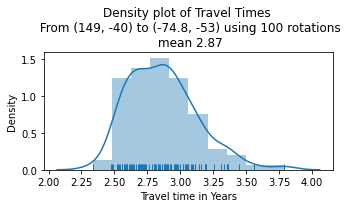

In [6]:
tt = [path.sp.travel_time for path in sps]
tt = [x/365 for x in tt if x!=-1]
print(len(tt))
fig, ax = plt.subplots(figsize=(5,3))
sns.distplot(tt, ax=ax, rug=True, kde_kws = {"bw":0.09})
ax.set_title(f'Density plot of Travel Times \n From {loc1} to {loc2} using 100 rotations\n mean {round(np.mean(tt),2)}')
ax.set_xlabel("Travel time in Years")
ax.set_ylabel("Density")
fig.tight_layout()
fig.savefig("Images/RareComp_density.pdf")